In [56]:
import src.MCTS as MCTS
from src.Environments import StatelessGym
from src.Experiment import Experiment, RandomExperiment, ParametrizedRandomExperiment
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.metrics import median_absolute_error, mean_squared_log_error, max_error
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, mean_tweedie_deviance
from sklearn.preprocessing import OneHotEncoder
import ast
import math

def encode_maze(maze):
    num_rows = len(maze)
    num_cols = len(maze[0])

    encoded_maze = []

    for i in range(num_rows):
        for j in range(num_cols):
            if maze[i][j] == 'S':
                encoded_maze.append(0)
            elif maze[i][j] == 'F':
                encoded_maze.append(1)
            elif maze[i][j] == 'H':
                encoded_maze.append(2)
            elif maze[i][j] == 'G':
                encoded_maze.append(3)
            elif maze[i][j] == 'E':
                encoded_maze.append(4)
    return encoded_maze

def add_padding(map, target_size):
    current_size = len(map)
    diff = target_size - current_size
    if diff < 0:
        raise Exception("Current map size is greater than target size")
    elif diff == 0:
        return map
    else:
        result = []
        padding = diff // 2
        left_out = diff % 2
        for i in range(padding):
            result.append('E' * target_size)
        for row in map:
            new_row = 'E' * padding + row + 'E' * padding + 'E' * left_out
            result.append(new_row)
        for i in range(padding + left_out):
            result.append('E' * target_size)
        return result
    
def encode_map(map, categories='auto'):
    # Convert the map to a 2D array
    map_array =  []
    for row in map:
        for letter in row:
            map_array.append([letter])
    # Create an instance of OneHotEncoder
    encoder = OneHotEncoder(sparse=False, categories=categories)

    # Fit and transform the map array
    encoded_map = encoder.fit_transform(map_array).astype('int64')

    # Get the categories (unique values) from the encoder
    categories = encoder.categories_[0]

    # Create a dictionary to map the encoded values to the original categories
    category_mapping = {i: category for i, category in enumerate(categories)}

    # Return the encoded map and the category mapping
    return encoded_map, encoder.categories_, category_mapping

            

In [104]:
import ast
directory = "../datasets/CartPole-v1_disc-default_s1-100_t500/"
dataset_names = os.listdir(directory)
dataset = pd.DataFrame()
print (dataset_names)

for dataset_name in dataset_names:
    dataset = dataset.append(pd.read_csv(directory + dataset_name), ignore_index=True)
    
padding = 4

if 'Map' in dataset.columns:
    if padding > 0: 
        dataset['List_Map'] = dataset['Map'].apply(ast.literal_eval).apply(lambda x: add_padding(x, padding))
    else: 
        dataset['List_Map'] = dataset['Map'].apply(ast.literal_eval)
    #dataset['F_count'] = dataset['Map'].apply(lambda x: sum(row.count('F') for row in x))
    dataset['Encoded_Map'] = dataset['List_Map'].apply(lambda x: encode_maze(x))
    categories = encode_map(dataset['List_Map'].iloc[0])[1]
    print(categories)
    dataset['OneHotEncoded_Map'] = dataset['List_Map'].apply(lambda x: np.reshape(encode_map(x, categories)[0], (-1)))
print(dataset)
dataset.describe()

['CartPole-v1_disc-default_100_s1_100_t500_1 (1).csv', 'CartPole-v1_disc-default_100_s1_100_t500_1 (10).csv', 'CartPole-v1_disc-default_100_s1_100_t500_1 (2).csv', 'CartPole-v1_disc-default_100_s1_100_t500_1 (3).csv', 'CartPole-v1_disc-default_100_s1_100_t500_1 (4).csv', 'CartPole-v1_disc-default_100_s1_100_t500_1 (5).csv', 'CartPole-v1_disc-default_100_s1_100_t500_1 (6).csv', 'CartPole-v1_disc-default_100_s1_100_t500_1 (7).csv', 'CartPole-v1_disc-default_100_s1_100_t500_1 (8).csv', 'CartPole-v1_disc-default_100_s1_100_t500_1 (9).csv', 'CartPole-v1_disc-default_100_s1_100_t500_1.csv', 'CartPole-v1_disc-default_100_s1_100_t500_10.csv', 'CartPole-v1_disc-default_100_s1_100_t500_2.csv', 'CartPole-v1_disc-default_100_s1_100_t500_3.csv', 'CartPole-v1_disc-default_100_s1_100_t500_4.csv', 'CartPole-v1_disc-default_100_s1_100_t500_5.csv', 'CartPole-v1_disc-default_100_s1_100_t500_6.csv', 'CartPole-v1_disc-default_100_s1_100_t500_7.csv', 'CartPole-v1_disc-default_100_s1_100_t500_8.csv', 'CartPo

,Temperature,Cart Position,Cart Velocity,Pole Angle,Pole Angular Velocity,Simulations,Return,Discounted Return
count,2000.0,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000
mean,500.0,-0.000750,-0.001340,0.00078,0.000905,49.694000,457.116500,245.202150
std,0.0,0.031668,0.031194,0.03160,0.031991,29.346345,87.166266,33.442226
min,500.0,-0.050000,-0.050000,-0.05000,-0.050000,1.000000,10.000000,9.866074
25%,500.0,-0.030000,-0.030000,-0.03000,-0.030000,24.000000,458.000000,249.143189
50%,500.0,0.000000,0.000000,0.00000,0.000000,48.000000,500.000000,259.124107
75%,500.0,0.030000,0.030000,0.03000,0.030000,76.000000,500.000000,259.124107
max,500.0,0.050000,0.050000,0.05000,0.050000,100.000000,500.000000,259.124107


In [43]:
lan = dataset['OneHotEncoded_Map'].apply(pd.Series).values

In [44]:
print(dataset["Map"].iloc[635524])
print(dataset["OneHotEncoded_Map"].iloc[635524].shape)
print(lan[635524])

['SFFF', 'FFFF', 'FFFF', 'FFFG']
(64,)
[0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1
 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0]


In [25]:
i = 0
for encoded_map in lan:
    for code in encoded_map:
        if not code >= 0:
            print(i)
            pass
    i+=1

635524
635524
635524
635524
635524
635524
635524
635524
635524
635524
635524
635524
635524
635524
635524
635524
635944
635944
635944
635944
635944
635944
635944
635944
635944
635944
635944
635944
635944
635944
635944
635944
636510
636510
636510
636510
636510
636510
636510
636510
636510
636510
636510
636510
636510
636510
636510
636510
637607
637607
637607
637607
637607
637607
637607
637607
637607
637607
637607
637607
637607
637607
637607
637607
638104
638104
638104
638104
638104
638104
638104
638104
638104
638104
638104
638104
638104
638104
638104
638104
638130
638130
638130
638130
638130
638130
638130
638130
638130
638130
638130
638130
638130
638130
638130
638130
641021
641021
641021
641021
641021
641021
641021
641021
641021
641021
641021
641021
641021
641021
641021
641021
643488
643488
643488
643488
643488
643488
643488
643488
643488
643488
643488
643488
643488
643488
643488
643488
644150
644150
644150
644150
644150
644150
644150
644150
644150
644150
644150
644150
644150
644150
644150

In [59]:
models = {
    #'LinearRegression': LinearRegression(),
    # #'Ridge': Ridge(alpha=1.0),
    # #'Lasso': Lasso(alpha=1.0),
    # #'ElasticNet':  ElasticNet(alpha=1.0, l1_ratio=0.5),
    #'SVR': SVR(),
    #'DecisionTreeRegressor': DecisionTreeRegressor(),
    #'RandomForestRegressor': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators=100, max_depth=10),
    #'KNeighborsRegressor': KNeighborsRegressor(n_neighbors=5),
    #'MLPRegressor': MLPRegressor(hidden_layer_sizes=(150, 150, 150), activation='tanh', max_iter=1000000, n_iter_no_change=10, tol=1e-4)
}

## Analysis

In [112]:
# Checking some errors
a = dataset.groupby(["Simulations", "Pole Angle"])["Discounted Return"]
print(a.describe())
errors = a.std() / (a.count() ** 0.5)
print(errors.describe())
errors = errors[errors > 0.05]
print(len(errors))
print(type(errors))
# for index, vals in errors.items():
#     print(index[0], index[1], vals)

                        count        mean       std         min         25%  \
Simulations Pole Angle                                                        
1           -0.05         2.0   25.967308  2.611976   24.120363   25.043836   
            -0.04         3.0   15.941623  4.521248   10.836476   14.192369   
            -0.03         1.0   26.894939       NaN   26.894939   26.894939   
            -0.01         4.0   18.662088  7.668006    9.866074   13.483312   
             0.01         1.0   10.836476       NaN   10.836476   10.836476   
...                       ...         ...       ...         ...         ...   
100          0.00         4.0  259.124107  0.000000  259.124107  259.124107   
             0.01         2.0  253.624696  7.777342  248.125285  250.874991   
             0.02         1.0  259.124107       NaN  259.124107  259.124107   
             0.04         1.0  259.124107       NaN  259.124107  259.124107   
             0.05         2.0  257.761925  1.926417 

Simulations
1       21.898329
2      179.172221
3      188.209865
4      206.590589
5      220.469646
6      203.909112
7      222.366455
8      230.965615
9      213.358132
10     222.420011
11     242.346410
12     228.227314
13     241.058701
14     234.222470
15     243.733797
16     237.766334
17     233.657078
18     244.485120
19     256.621060
20     237.919276
21     246.718852
22     248.872495
23     227.269722
24     241.481360
25     240.862520
26     239.019183
27     243.223010
28     256.049784
29     252.880356
30     246.547985
31     250.632547
32     251.725834
33     246.029700
34     244.413630
35     251.372381
36     244.898767
37     254.587094
38     246.865332
39     256.382213
40     249.001392
41     255.362692
42     247.630746
43     248.980215
44     251.800043
45     253.943406
46     257.988572
47     251.471438
48     254.720784
49     253.647314
50     253.227984
51     253.274721
52     249.879850
53     256.166024
54     249.449115
55     251.58687

<ErrorbarContainer object of 3 artists>

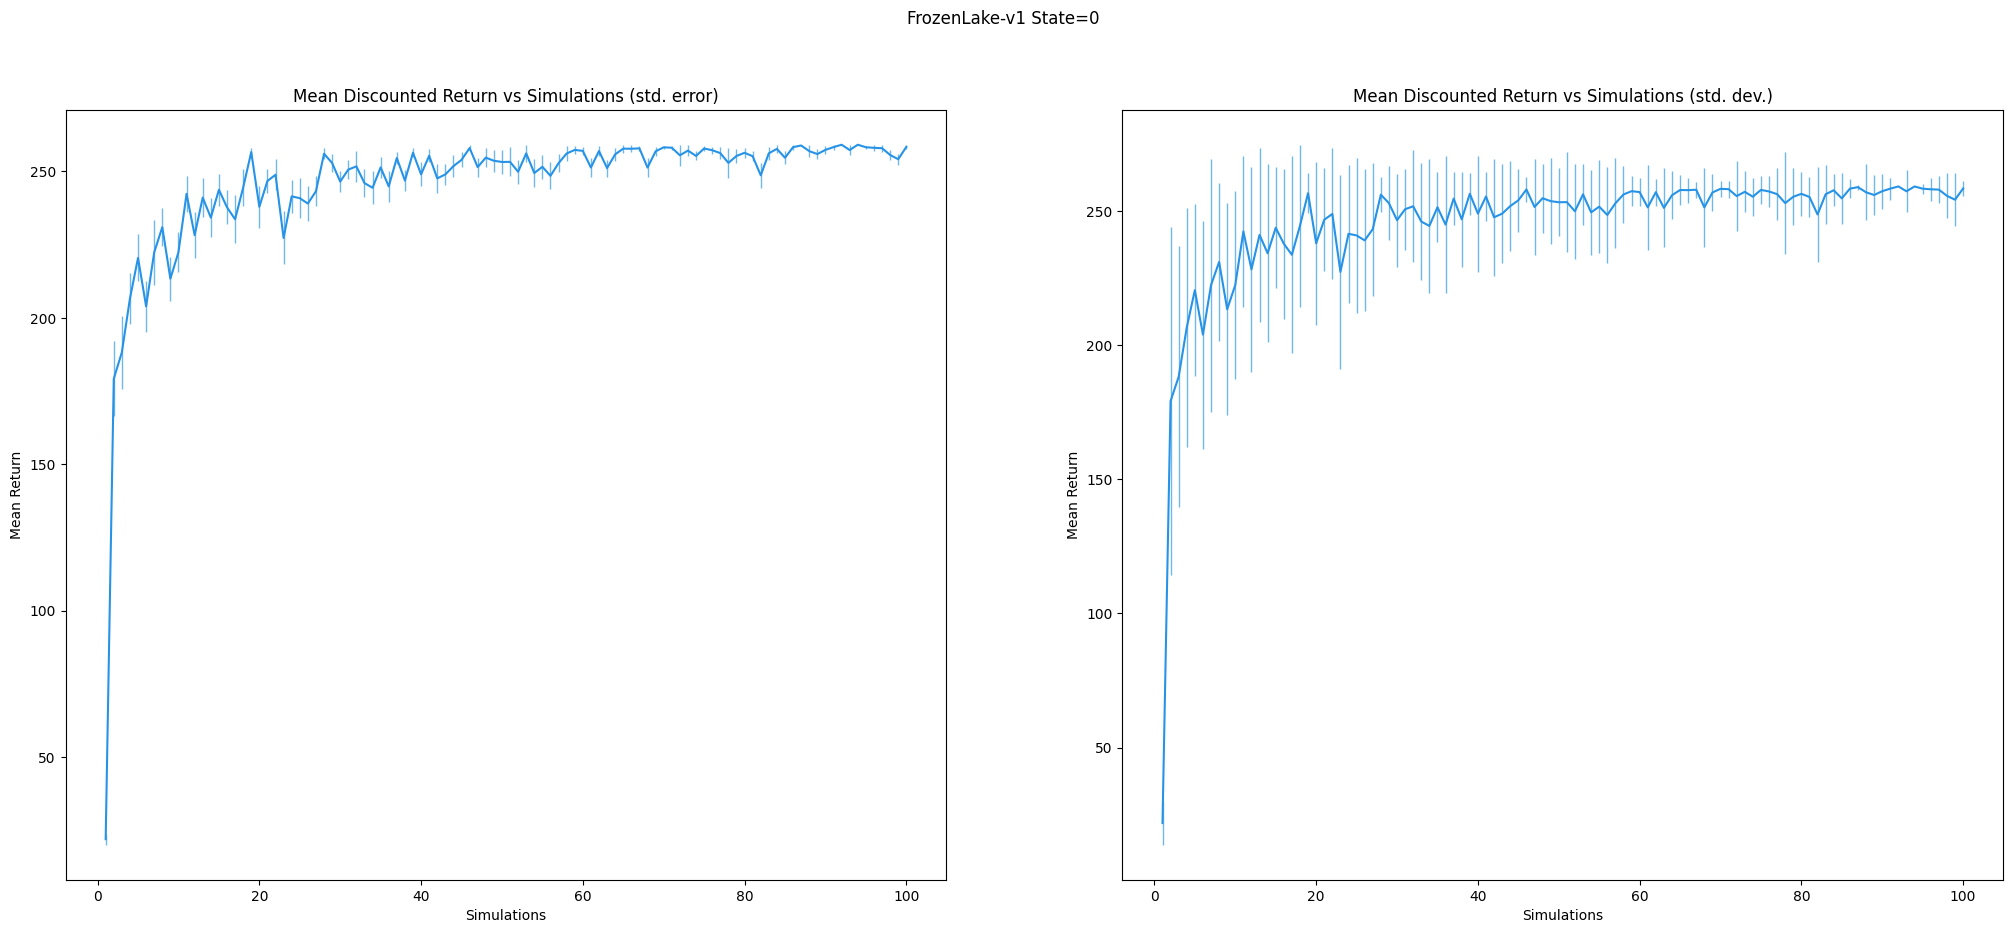

In [111]:
group_simulation = dataset.groupby("Simulations")
mean_returns = group_simulation["Discounted Return"].mean()
std_returns = group_simulation["Discounted Return"].std()
error_returns = std_returns / (group_simulation["Discounted Return"].count() ** 0.5)

print(mean_returns.to_string())
print(error_returns.to_string())

#plt.errorbar(list(group_simulation.indices.keys()),  mean_returns, yerr=error_returns.array)
#plt.errorbar(list(group_simulation.indices.keys()),  mean_returns, yerr=error_returns.array)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('FrozenLake-v1 State=0')
fig.set_size_inches(25, 10)

ax1.set_title("Mean Discounted Return vs Simulations (std. error)")
ax2.set_title("Mean Discounted Return vs Simulations (std. dev.)")
ax1.xaxis.set_label_text("Simulations")
ax1.yaxis.set_label_text("Mean Return")
ax2.xaxis.set_label_text("Simulations")
ax2.yaxis.set_label_text("Mean Return")

ax1.errorbar(list(group_simulation.indices.keys()),  mean_returns, yerr=error_returns.array, color="#2793e6", ecolor="#2793e6aa", elinewidth=1, label="Temp=%d" % dataset["Temperature"].iloc[0])
ax2.errorbar(list(group_simulation.indices.keys()),  mean_returns, yerr=std_returns.array, color="#2793e6", ecolor="#2793e6aa", elinewidth=1, label="Temp=%d" % dataset["Temperature"].iloc[0])

<AxesSubplot:xlabel='Initial State'>

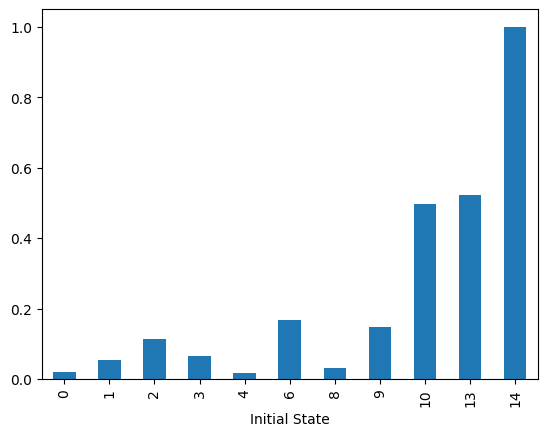

In [40]:
sim = 5
grouped = dataset[dataset["Simulations"] == sim].groupby("Initial State")["Discounted Return"]
grouped.mean().plot.bar()

## Without Maps

### Without Initial State

Training set size: 100
Training error 1: 0.077041 ± 0.000804
Training error 2: 850.655318 ± 37.538051
Test error: 614.198639 ± 27.142117

Training set size: 225
Training error 1: 0.077041 ± 0.000804
Training error 2: 623.196264 ± 21.464661
Test error: 639.929712 ± 21.779924

Training set size: 350
Training error 1: 0.077041 ± 0.000804
Training error 2: 503.676131 ± 14.886530
Test error: 585.642743 ± 16.567310

Training set size: 475
Training error 1: 0.077041 ± 0.000804
Training error 2: 433.285417 ± 7.876164
Test error: 575.742264 ± 14.241440

Training set size: 600
Training error 1: 0.077041 ± 0.000804
Training error 2: 382.194471 ± 6.538091
Test error: 541.744754 ± 9.848787

Training set size: 725
Training error 1: 0.077041 ± 0.000804
Training error 2: 345.485782 ± 5.784483
Test error: 605.119042 ± 13.384920

Training set size: 850
Training error 1: 0.077041 ± 0.000804
Training error 2: 312.848198 ± 5.569139
Test error: 554.651213 ± 11.775189

Training set size: 975
Training error 1

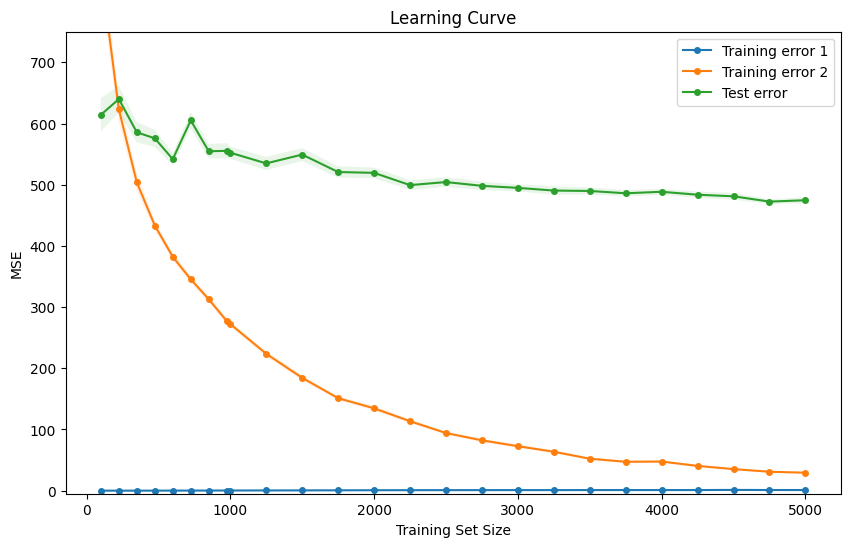

In [166]:
#Getting min and max number of simulations
sim_min = dataset['Simulations'].min()
sim_max = dataset['Simulations'].max()

#Features to be used in the model
features = ['Simulations', 'Pole Angle']

#Folds
fold = 50
#test_sims = np.sort(np.random.choice(np.arange(sim_min, sim_max + 1), size=math.ceil((sim_max - sim_min + 1) * 0.33), replace=False))
test_sims = [ 3, 5, 9, 13, 14, 18, 21, 25, 26, 27, 29, 38, 41, 43, 47, 48, 53, 55, 59, 60, 65, 67, 69, 70, 75, 78, 84, 85, 86, 89, 90, 96, 98]
train_sizes = list(range(100, 1001, 125)) + list(range(1000, 5001, 250))
#train_sizes = [5]
train_scores = []
train_scores2 = []
test_scores = []

for training_set_size in  train_sizes:
    train_scores.append([])
    train_scores2.append([])
    test_scores.append([])
    
    for i in range(fold):
        #Randomly sampling number of simulations to be included in the test and training set
        training_sims = np.setdiff1d(np.arange(sim_min, sim_max + 1), test_sims)

        #Creating test set by taking average for test set simulations
        test_set = dataset[dataset['Simulations'].isin(test_sims)].groupby(features)['Discounted Return'].mean()
        data = test_set.index.values
        categorical_values = [x[0] for x in data]
        numerical_values = [x[1] for x in data]

        # Convert lists to numpy arrays
        categorical_values = np.array(categorical_values).reshape(-1, 1)
        numerical_values = np.array(numerical_values).reshape(-1, 1)

        test_set_x = np.hstack((categorical_values, numerical_values))
        #test_set_x = test_set.index.values.reshape(-1, len(features))
        test_set_y = test_set.values
        
        #Creating training set by sampling sim numbers for training set from the remainnig datapoints
        training_set = dataset[dataset['Simulations'].isin(training_sims)].sample(n=training_set_size, replace=True)
        
        training_set_x = training_set[features].values.reshape(-1, len(features))
        training_set_y = training_set['Discounted Return'].values
        
        #Creating training score sets
        training_score_set = training_set.groupby(features)['Discounted Return'].mean()
        data = training_score_set.index.values
        categorical_values = [x[0] for x in data]
        numerical_values = [x[1] for x in data]
        # Convert lists to numpy arrays
        categorical_values = np.array(categorical_values).reshape(-1, 1)
        numerical_values = np.array(numerical_values).reshape(-1, 1)
        training_score_set_x = np.hstack((categorical_values, numerical_values))
        training_score_set_y = training_score_set.values
        
        training_score_set2 = dataset[dataset['Simulations'].isin(training_sims)].groupby(features)['Discounted Return'].mean()
        data = training_score_set2.index.values
        categorical_values = [x[0] for x in data]
        numerical_values = [x[1] for x in data]
        # Convert lists to numpy arrays
        categorical_values = np.array(categorical_values).reshape(-1, 1)
        numerical_values = np.array(numerical_values).reshape(-1, 1)
        training_score_set2_x = np.hstack((categorical_values, numerical_values))
        training_score_set2_y = training_score_set2.values
        # print(test_sims)
        # print(training_score_set)
        # print(training_score_set_x.shape)
        # print(training_score_set_y.shape)

        #Training
        for model_name, model in models.items():
            model.fit(training_set_x, training_set_y)
            #Predicting on test set
            y_pred = model.predict(test_set_x)
            #Calculating MSE
            test_score = mean_squared_error(test_set_y, y_pred)
            test_scores[-1].append(test_score)
            #Predicting on training set
            y_pred = model.predict(training_score_set_x)
            train_score = mean_squared_error(training_score_set_y, y_pred)
            train_scores[-1].append(train_score)
            
            y_pred = model.predict(training_score_set2_x)
            train_score2 = mean_squared_error(training_score_set2_y, y_pred)
            train_scores2[-1].append(train_score2)
    print("Training set size: %d\nTraining error 1: %f ± %f\nTraining error 2: %f ± %f\nTest error: %f ± %f\n" % (training_set_size, np.mean(train_scores1[-1]), np.std(train_scores1[-1]) / (fold ** 0.5), np.mean(train_scores2[-1]), np.std(train_scores2[-1]) / (fold ** 0.5), np.mean(test_scores[-1]), np.std(test_scores[-1]) / (fold ** 0.5)))
        
# Calculate the mean and standard deviation of the training and test scores
train1_mean = np.mean(train_scores, axis=1)
train1_std = np.std(train_scores, axis=1) / (fold ** 0.5)
train2_mean = np.mean(train_scores2, axis=1)
train2_std = np.std(train_scores2, axis=1) / (fold ** 0.5)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1) / (fold ** 0.5)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train1_mean, marker='o', markersize=4, label='Training error 1')
plt.plot(train_sizes, train2_mean, marker='o', markersize=4, label='Training error 2')
plt.plot(train_sizes, test_mean, marker='o', markersize=4, label='Test error')

# Add error bands showing the standard deviation
plt.fill_between(train_sizes, train1_mean - train1_std, train1_mean + train1_std, alpha=0.1)
plt.fill_between(train_sizes, train2_mean - train2_std, train2_mean + train2_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

# Add labels and title
plt.xlabel('Training Set Size')
plt.ylabel('MSE')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.ylim([-5, 750])
plt.show()

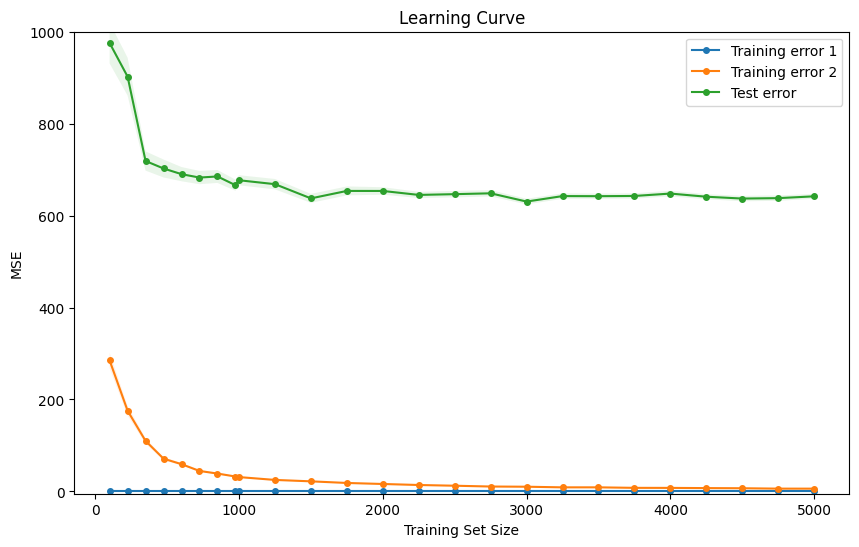

In [93]:
# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train1_mean, marker='o', markersize=4, label='Training error 1')
plt.plot(train_sizes, train2_mean, marker='o', markersize=4, label='Training error 2')
plt.plot(train_sizes, test_mean, marker='o', markersize=4, label='Test error')

# Add error bands showing the standard deviation
plt.fill_between(train_sizes, train1_mean - train1_std, train1_mean + train1_std, alpha=0.1)
plt.fill_between(train_sizes, train2_mean - train2_std, train2_mean + train2_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

# Add labels and title
plt.xlabel('Training Set Size')
plt.ylabel('MSE')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.ylim([-5, 1000])
plt.show()

### With initial state

Training set size: 10
Training error 1: 0.000000 ± 0.000000
Training error 2: 0.036031 ± 0.008812
Test error: 0.041237 ± 0.027283

Training set size: 135
Training error 1: 0.000000 ± 0.000000
Training error 2: 0.025642 ± 0.007660
Test error: 0.034998 ± 0.008465

Training set size: 260
Training error 1: 0.000000 ± 0.000000
Training error 2: 0.033559 ± 0.003783
Test error: 0.052412 ± 0.003765

Training set size: 385
Training error 1: 0.000000 ± 0.000000
Training error 2: 0.023001 ± 0.005359
Test error: 0.027772 ± 0.004432

Training set size: 510
Training error 1: 0.000000 ± 0.000000
Training error 2: 0.020846 ± 0.004447
Test error: 0.031694 ± 0.009491

Training set size: 635
Training error 1: 0.000000 ± 0.000000
Training error 2: 0.021697 ± 0.006988
Test error: 0.035539 ± 0.005417

Training set size: 760
Training error 1: 0.000001 ± 0.000000
Training error 2: 0.023665 ± 0.001626
Test error: 0.034955 ± 0.014042

Training set size: 885
Training error 1: 0.000001 ± 0.000001
Training error 2

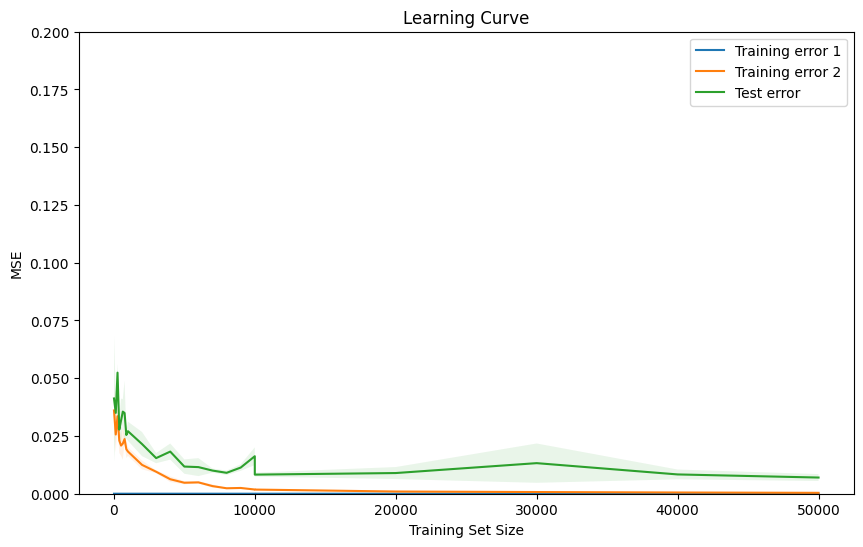

In [35]:
#Getting min and max number of simulations
sim_min = dataset['Simulations'].min()
sim_max = dataset['Simulations'].max()

#Features to be used in the model
features = ['Simulations', 'Initial State']

#Unique states
unique_states = []
for state in dataset["Initial State"].unique():
    unique_states.append(state)
state_count = len(unique_states)

#Folds
fold = 3

train_sizes = list(range(10, 1001, 125)) + list(range(1000, 10001, 1000)) + list(range(10000, 50001, 10000))
train_scores1 = []
train_scores2 = []
test_scores = []

for training_set_size in  train_sizes:
    train_scores1.append([])
    train_scores2.append([])
    test_scores.append([])
    
    for i in range(fold):
        #Randomly sampling number of simulations to be included in the test and training set
        test_states = np.sort(np.random.choice(unique_states, size=math.ceil(state_count * 0.33), replace=False))
        #training_sims = np.setdiff1d(np.arange(sim_min, sim_max + 1), test_sims)

        #Creating test set by taking average for test set simulations
        test_set = dataset[dataset['Initial State'].isin(test_states)].groupby(["Simulations", "Initial State"]).mean()["Discounted Return"]
        #test_set_x = test_set.groupby(['Simulations', 'Initial State']).mean()[features].values.reshape(-1, len(features))
        #test_set_y = dataset.loc[dataset['Initial State'].isin(test_states)].groupby(['Simulations', 'Initial State']).mean()['Discounted Return'].values
        test_set_x = []
        test_set_y = []
        for i in range(len(test_set)):
            test_set_x.append([test_set.index[i][0], test_set.index[i][1]])
            test_set_y.append(test_set.values[i])
        #Creating training set by sampling sim numbers for training set from the remainnig datapoints
        training_set = dataset[~dataset['Initial State'].isin(test_states)]
        training_set_sampled = training_set.sample(n=training_set_size, replace=True)
        
        training_set_x = training_set_sampled[features].values.reshape(-1, len(features))
        training_set_y = training_set_sampled['Discounted Return'].values
        
        # Training score 1 set
        training_score1_set = training_set_sampled.groupby(["Initial State", "Simulations"]).mean()["Discounted Return"]
        training_score1_set_x = []
        training_score1_set_y = []
        for i in range(len(training_score1_set)):
            training_score1_set_x.append([training_score1_set.index[i][1], training_score1_set.index[i][0]])
            training_score1_set_y.append(training_score1_set.values[i])
            
        #Creating Training Score 2 Set - Looking all datapoints in the training sample
        training_sampled_unique = training_set_sampled["Initial State"].unique()
        training_score2_set = training_set[training_set["Initial State"].isin(training_sampled_unique)].groupby(["Initial State", "Simulations"]).mean()["Discounted Return"]
        training_score2_set_x = []
        training_score2_set_y = []
        for i in range(len(training_score2_set)):
            training_score2_set_x.append([training_score2_set.index[i][1], training_score2_set.index[i][0]])
            training_score2_set_y.append(training_score2_set.values[i])
        # print(test_sims)
        # print(training_score_set)
        # print(training_score_set_x.shape)
        # print(training_score_set_y.shape)

        #Training
        for model_name, model in models.items():
            model.fit(training_set_x, training_set_y)
            
            #Predicting on test set
            y_pred = model.predict(test_set_x)
            test_score = mean_squared_error(test_set_y, y_pred)
            test_scores[-1].append(test_score)
            
            #Predicting on training score 1 set
            y_pred = model.predict(training_score1_set_x)
            train_score1 = mean_squared_error(training_score1_set_y, y_pred)
            train_scores1[-1].append(train_score1)
            
            #Predicting on training score 2 set
            y_pred = model.predict(training_score2_set_x)
            train_score2 = mean_squared_error(training_score2_set_y, y_pred)
            train_scores2[-1].append(train_score2)
            
        # print("Fold: %d\nTraining set size: %d\nTraining error: %f\nTest error: %f\n" % (i, training_set_size, train_score, test_score))
    print("Training set size: %d\nTraining error 1: %f ± %f\nTraining error 2: %f ± %f\nTest error: %f ± %f\n" % (training_set_size, np.mean(train_scores1[-1]), np.std(train_scores1[-1]), np.mean(train_scores2[-1]), np.std(train_scores2[-1]), np.mean(test_scores[-1]), np.std(test_scores[-1])))
        
# Calculate the mean and standard deviation of the training and test scores
train1_mean = np.mean(train_scores1, axis=1)
train1_std = np.std(train_scores1, axis=1)
train2_mean = np.mean(train_scores2, axis=1)
train2_std = np.std(train_scores2, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train1_mean, label='Training error 1')
plt.plot(train_sizes, train2_mean, label='Training error 2')
plt.plot(train_sizes, test_mean, label='Test error')

# Add error bands showing the standard deviation
plt.fill_between(train_sizes, train1_mean - train1_std, train1_mean + train1_std, alpha=0.1)
plt.fill_between(train_sizes, train2_mean - train2_std, train2_mean + train2_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

# Add labels and title
plt.xlabel('Training Set Size')
plt.ylabel('MSE')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.ylim([0.0, 0.1])
plt.show()

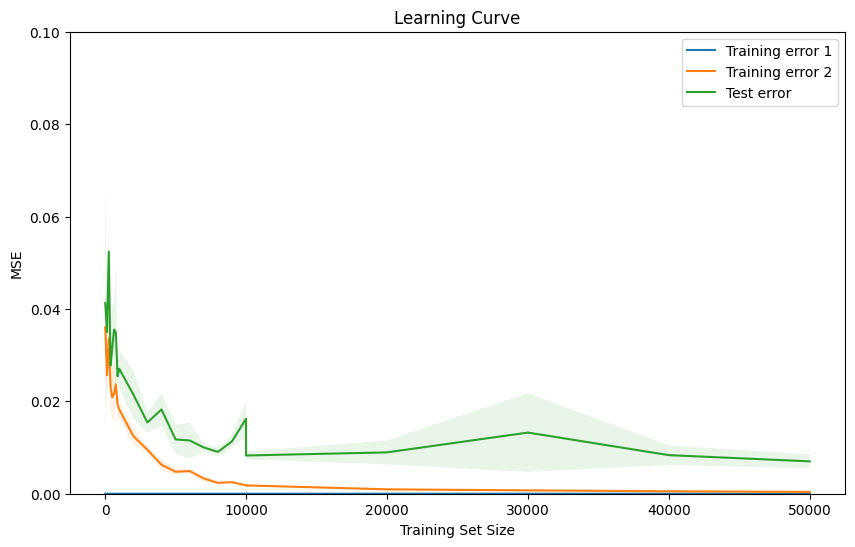

In [36]:
# Calculate the mean and standard deviation of the training and test scores
train1_mean = np.mean(train_scores1, axis=1)
train1_std = np.std(train_scores1, axis=1)
train2_mean = np.mean(train_scores2, axis=1)
train2_std = np.std(train_scores2, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train1_mean, label='Training error 1')
plt.plot(train_sizes, train2_mean, label='Training error 2')
plt.plot(train_sizes, test_mean, label='Test error')

# Add error bands showing the standard deviation
plt.fill_between(train_sizes, train1_mean - train1_std, train1_mean + train1_std, alpha=0.1)
plt.fill_between(train_sizes, train2_mean - train2_std, train2_mean + train2_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

# Add labels and title
plt.xlabel('Training Set Size')
plt.ylabel('MSE')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.ylim([0.0, 0.1])
plt.show()

## With Different Maps

In [19]:
training_set_size = 75000

#Unique maps
unique_maps = []
for map in dataset["Map"].unique():
    unique_maps.append(map)
map_count = len(unique_maps)
test_maps = np.random.default_rng().choice(unique_maps, size=500, replace=False)
print("Total unique: ", map_count)

#Creating Test Set
test_set = dataset[dataset['Map'].isin(test_maps)].groupby(["Map", "Simulations"]).mean()["Discounted Return"]
test_set_x = []
test_set_y = []
print(type(test_set))
for i in range(len(test_set)):
    test_set_x.append([test_set.index[i][1]] + encode_maze(test_set.index[i][0]))
    test_set_y.append(test_set[i])

#Creating Training Set
training_set = dataset[~dataset['Map'].isin(test_maps)]
training_set_sampled = training_set.sample(n=training_set_size, replace=False)
training_set_x = np.append(training_set_sampled["Simulations"].values.reshape(-1, 1), training_set_sampled['Encoded_Map'].apply(pd.Series).values, axis=1)
training_set_y = training_set_sampled["Discounted Return"].values

#Creating Training Score Set
training_score_set = training_set.groupby(["Map", "Simulations"]).mean()["Discounted Return"]
training_score_set_x = []
training_score_set_y = []
for i in range(len(training_score_set)):
    training_score_set_x.append([training_score_set.index[i][1]] + encode_maze(training_score_set.index[i][0]))
    training_score_set_y.append(training_score_set[i])

#Creating Training Score 2 Set - Looking all datapoints in the training sample
training_sampled_unique = training_set_sampled["Map"].unique()
training_score2_set = training_set[training_set["Map"].isin(training_sampled_unique)].groupby(["Map", "Simulations"]).mean()["Discounted Return"]
training_score2_set_x = []
training_score2_set_y = []
for i in range(len(training_score2_set)):
    training_score2_set_x.append([training_score2_set.index[i][1]] + encode_maze(training_score2_set.index[i][0]))
    training_score2_set_y.append(training_score2_set[i])


print("Training unique: ", len(training_sampled_unique))
print("Test uniuqe: ", len(test_maps))
print("Missing: ", map_count - len(training_sampled_unique) - len(test_maps))
print("Training score2 set: ", len(training_score2_set))

#test_set.describe()
# print(training_score_set_x)
print(len(test_set_y))

Total unique:  3828
<class 'pandas.core.series.Series'>


KeyboardInterrupt: 

In [17]:
print("Missing: ", len(dataset) - len(dataset[dataset['Map'].isin(test_maps)]) - len(training_score2_set))

Missing:  0


In [90]:
#Unique maps
unique_maps = []
for map in dataset["Map"].unique():
    if len(ast.literal_eval(map)) == 7:
        unique_maps.append(map)
map_count = len(unique_maps)
print("Number of unique maps: ", map_count)

Number of unique maps:  29193


[[90  0  0 ...  1  0  0]
 [ 4  0  0 ...  1  0  0]
 [47  0  0 ...  1  0  0]
 ...
 [60  0  0 ...  1  0  0]
 [85  0  0 ...  1  0  0]
 [57  0  0 ...  1  0  0]]
[[98  0  0 ...  1  0  0]
 [16  0  0 ...  1  0  0]
 [76  0  0 ...  1  0  0]
 ...
 [52  0  0 ...  1  0  0]
 [21  0  0 ...  1  0  0]
 [44  0  0 ...  1  0  0]]
[[92  0  0 ...  1  0  0]
 [26  0  0 ...  1  0  0]
 [18  0  0 ...  1  0  0]
 ...
 [61  0  0 ...  1  0  0]
 [80  0  0 ...  1  0  0]
 [10  0  0 ...  1  0  0]]
Training set size: 1000
Training error 1: 0.077041 ± 0.003282
Training error 2: 0.372672 ± 0.009537
Test error: 0.111797 ± 0.003160



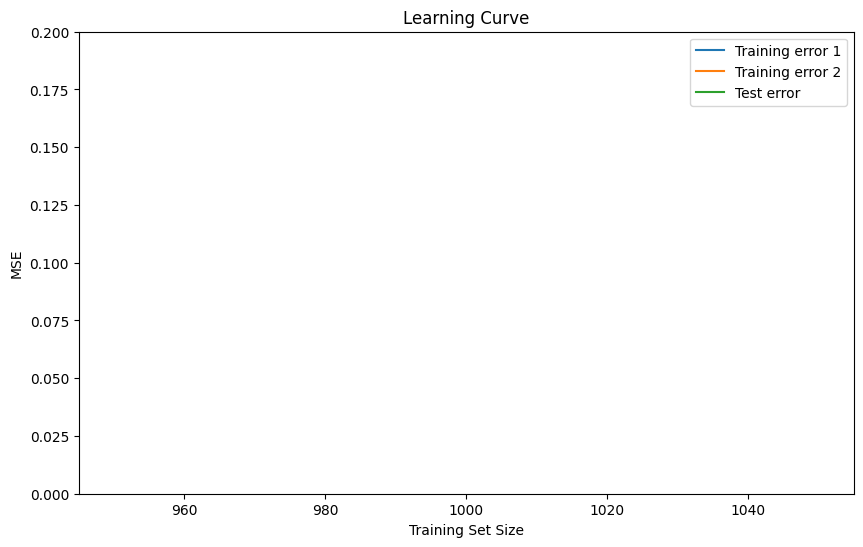

In [53]:
#Getting min and max number of simulations
sim_min = dataset['Simulations'].min()
sim_max = dataset['Simulations'].max()

#Features to be used in the model
features = ['Simulations']

#Unique maps
unique_maps = []
for map in dataset["Map"].unique():
    unique_maps.append(map)
map_count = len(unique_maps)
categories = encode_map(dataset['List_Map'].iloc[0])[1]
#Folds
fold = 3

#Test set size
test_set_size = math.ceil((map_count * 0.33))
#test_set_size = len(unique_maps) - 50
#Train set sizes
#train_sizes = [1, 8, 16, 25, 75, 100, 1000, 2000, 3000, 4000, 5000, 10000, 15000, 30000, 60000, 100000, 150000, 200000, 250000, 300000]
#train_sizes = train_sizes = list(range(10, 1000, 125)) + list(range(1000, 10000, 1000))
train_sizes = [1000]
#train_sizes = [1, 25, 100]

train_scores1 = []
train_scores2 = []
test_scores = []

one_hot = True
categories = encode_map(dataset['List_Map'].iloc[0])[1]

for training_set_size in  train_sizes:
    train_scores1.append([])
    train_scores2.append([])
    test_scores.append([])
    
    for i in range(fold):
        #Creating Test Set
        test_maps = np.random.default_rng().choice(unique_maps, size=test_set_size, replace=False)
        test_set = dataset[dataset['Map'].isin(test_maps)].groupby(["Map", "Simulations"]).mean()["Discounted Return"]
        test_set_x = []
        test_set_y = []
        for j in range(len(test_set)):
            if one_hot:
                test_set_x.append([test_set.index[j][1]] + list(np.reshape(encode_map(add_padding(ast.literal_eval(test_set.index[j][0]), padding), categories=categories)[0], (-1))))
            else:
                test_set_x.append([test_set.index[j][1]] + encode_maze(add_padding(ast.literal_eval(test_set.index[j][0]), padding)))
            test_set_y.append(test_set[j])

        #Creating Training Set
        training_set = dataset[~dataset['Map'].isin(test_maps)]
        training_set_sampled = training_set.sample(n=training_set_size, replace=False)
        if one_hot:
            training_set_x = np.append(training_set_sampled["Simulations"].values.reshape(-1, 1), training_set_sampled['OneHotEncoded_Map'].apply(pd.Series).values, axis=1).astype('int64')
        else:
            training_set_x = np.append(training_set_sampled["Simulations"].values.reshape(-1, 1), training_set_sampled['Encoded_Map'].apply(pd.Series).values, axis=1)
        training_set_y = training_set_sampled["Discounted Return"].values
        print(training_set_x)
        
        #print("Maps seen in training: %d" % (len(training_set["Map"].unique())))
        #Creating Training Score 1 Set - Looking only sampled points
        training_score1_set = training_set_sampled.groupby(["Map", "Simulations"]).mean()["Discounted Return"]
        training_score1_set_x = []
        training_score1_set_y = []
        for j in range(len(training_score1_set)):
            if one_hot:
                training_score1_set_x.append([training_score1_set.index[j][1]] + list(np.reshape(encode_map(add_padding(ast.literal_eval(training_score1_set.index[j][0]), padding), categories=categories)[0], (-1))))
            else:
                training_score1_set_x.append([training_score1_set.index[j][1]] + encode_maze(add_padding(ast.literal_eval(training_score1_set.index[j][0]), padding)))
            training_score1_set_y.append(training_score1_set[j])
            
        #Creating Training Score 2 Set - Looking all datapoints in the training sample
        training_sampled_unique = training_set_sampled["Map"].unique()
        training_score2_set = training_set[training_set["Map"].isin(training_sampled_unique)].groupby(["Map", "Simulations"]).mean()["Discounted Return"]
        training_score2_set_x = []
        training_score2_set_y = []
        for i in range(len(training_score2_set)):
            if one_hot:
                training_score2_set_x.append([training_score2_set.index[j][1]] + list(np.reshape(encode_map(add_padding(ast.literal_eval(training_score2_set.index[j][0]), padding), categories=categories)[0], (-1))))
            else:
                training_score2_set_x.append([training_score2_set.index[i][1]] + encode_maze(training_score2_set.index[i][0]))
            training_score2_set_y.append(training_score2_set[i])


        # print("train score set info: ")
        # a = (training_set.groupby(["Map", "Simulations"]).std()["Discounted Return"] / (training_set.groupby(["Map", "Simulations"]).count()["Discounted Return"] ** 0.5))
        # print(a.mean())
        # print("test set info: ")
        # b = (dataset[dataset['Map'].isin(test_maps)].groupby(["Map", "Simulations"]).std()["Discounted Return"] / (dataset[dataset['Map'].isin(test_maps)].groupby(["Map", "Simulations"]).count()["Discounted Return"] ** 0.5))
        # print(b.mean())
        #Training
        for model_name, model in models.items():
            model.fit(training_set_x, training_set_y)
            
            #Predicting on test set
            y_pred = model.predict(test_set_x)
            test_score = mean_squared_error(test_set_y, y_pred)
            test_scores[-1].append(test_score)
            
            #Predicting on training score 1 set
            y_pred = model.predict(training_score1_set_x)
            train_score1 = mean_squared_error(training_score1_set_y, y_pred)
            train_scores1[-1].append(train_score1)
            
            #Predicting on training score 2 set
            y_pred = model.predict(training_score2_set_x)
            train_score2 = mean_squared_error(training_score2_set_y, y_pred)
            train_scores2[-1].append(train_score2)
            
        # print("Fold: %d\nTraining set size: %d\nTraining error: %f\nTest error: %f\n" % (i, training_set_size, train_score, test_score))
    print("Training set size: %d\nTraining error 1: %f ± %f\nTraining error 2: %f ± %f\nTest error: %f ± %f\n" % (training_set_size, np.mean(train_scores1[-1]), np.std(train_scores1[-1]) / (fold ** 0.5), np.mean(train_scores2[-1]), np.std(train_scores2[-1]) / (fold ** 0.5), np.mean(test_scores[-1]), np.std(test_scores[-1]) / (fold ** 0.5)))
        
# Calculate the mean and standard deviation of the training and test scores
train1_mean = np.mean(train_scores1, axis=1)
train1_std = np.std(train_scores1, axis=1) / (fold ** 0.5)
train2_mean = np.mean(train_scores2, axis=1)
train2_std = np.std(train_scores2, axis=1) / (fold ** 0.5)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1) / (fold ** 0.5)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train1_mean, label='Training error 1')
plt.plot(train_sizes, train2_mean, label='Training error 2')
plt.plot(train_sizes, test_mean, label='Test error')

# Add error bands showing the standard deviation
plt.fill_between(train_sizes, train1_mean - train1_std, train1_mean + train1_std, alpha=0.1)
plt.fill_between(train_sizes, train2_mean - train2_std, train2_mean + train2_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

# Add labels and title
plt.xlabel('Training Set Size')
plt.ylabel('MSE')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.ylim([0.0, 0.2])
plt.show()

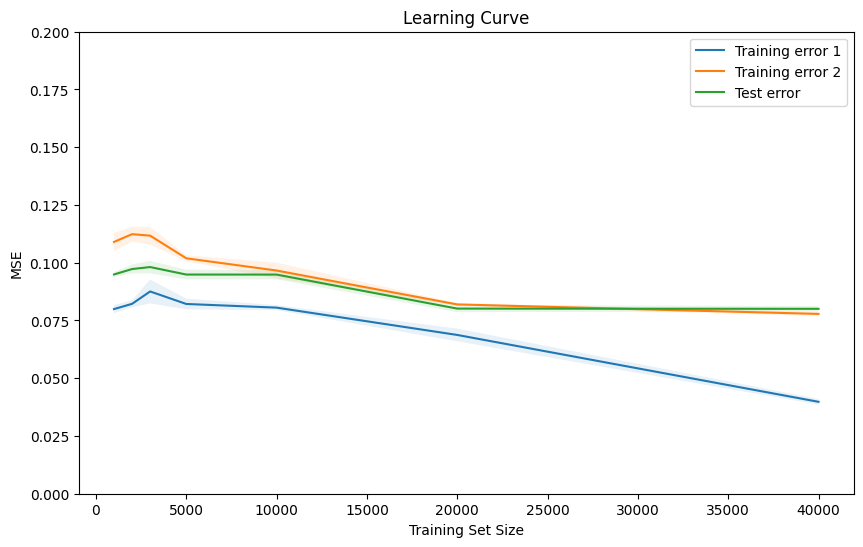

In [14]:
# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train1_mean, label='Training error 1')
plt.plot(train_sizes, train2_mean, label='Training error 2')
plt.plot(train_sizes, test_mean, label='Test error')

# Add error bands showing the standard deviation
plt.fill_between(train_sizes, train1_mean - train1_std, train1_mean + train1_std, alpha=0.1)
plt.fill_between(train_sizes, train2_mean - train2_std, train2_mean + train2_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

# Add labels and title
plt.xlabel('Training Set Size')
plt.ylabel('MSE')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.ylim([0.0, 0.20])
plt.show()

In [11]:
print(train_mean, train_std, test_mean, test_std)

[0.00000000e+00 2.14702190e-16 2.10826870e-16 4.55845133e-15
 7.77780409e-07 2.69708957e-05 3.81146905e-02 5.49393706e-02
 6.45275582e-02 6.51802651e-02 6.83914609e-02 6.85243081e-02
 7.12151742e-02 6.80887099e-02 6.42353502e-02 6.41943114e-02
 6.68044209e-02 6.84278883e-02 6.96860043e-02 7.22362140e-02] [0.00000000e+00 1.87456638e-18 5.48079409e-18 6.13572921e-15
 3.98679159e-07 2.61982122e-05 2.10927544e-03 5.50174316e-03
 1.73219011e-03 3.03818331e-03 1.53711792e-03 2.05788269e-03
 1.02808108e-03 4.33698388e-04 5.58471508e-04 7.39185021e-04
 6.67304172e-04 4.88120294e-04 3.36222368e-04 5.32103411e-04] [0.22476604 0.21984403 0.17999751 0.22562262 0.15456883 0.1556772
 0.10639668 0.09545906 0.08792098 0.08720874 0.08968134 0.08906839
 0.08394032 0.08229218 0.08252969 0.0813772  0.08166744 0.08276272
 0.0852662  0.07842087] [0.0101751  0.06617633 0.04482506 0.04732252 0.00761723 0.01452601
 0.00352707 0.00195306 0.00031663 0.00051078 0.00301702 0.00184991
 0.00367295 0.00121545 0.00208

## Unique Maps Seen

Unique trainig size: 1
Training error 1: 0.000000 ± 0.000000
Training error 2: 0.000003 ± 0.000002
Test error: 0.335602 ± 0.101633

Unique trainig size: 11
Training error 1: 0.000007 ± 0.000003
Training error 2: 0.002150 ± 0.001304
Test error: 0.180157 ± 0.035080

Unique trainig size: 21
Training error 1: 0.000062 ± 0.000020
Training error 2: 0.013710 ± 0.005357
Test error: 0.154258 ± 0.020446

Unique trainig size: 31
Training error 1: 0.000196 ± 0.000125
Training error 2: 0.016379 ± 0.003982
Test error: 0.127024 ± 0.008445

Unique trainig size: 41
Training error 1: 0.000145 ± 0.000090
Training error 2: 0.025308 ± 0.011191
Test error: 0.130402 ± 0.003451

Unique trainig size: 51
Training error 1: 0.000257 ± 0.000135
Training error 2: 0.029296 ± 0.001814
Test error: 0.127227 ± 0.003369

Unique trainig size: 61
Training error 1: 0.000198 ± 0.000059
Training error 2: 0.035764 ± 0.000999
Test error: 0.117281 ± 0.004498

Unique trainig size: 71
Training error 1: 0.000272 ± 0.000020
Training

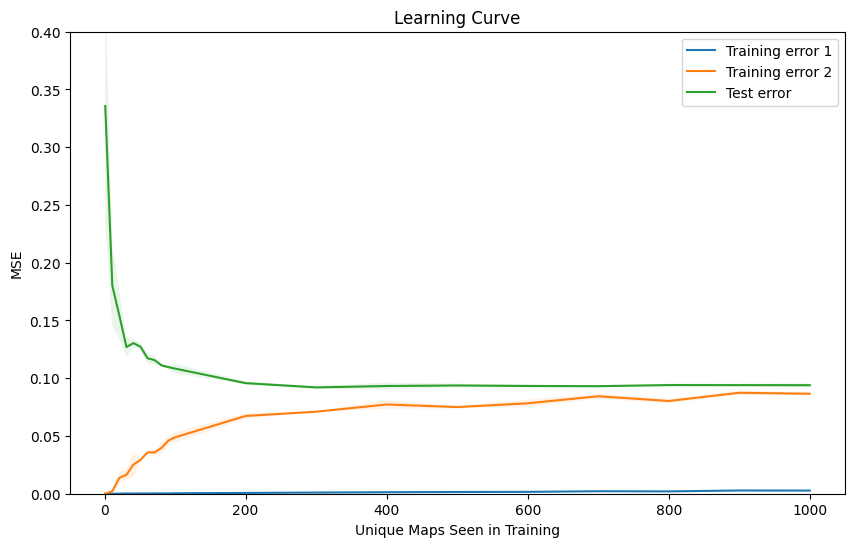

In [10]:
#Getting min and max number of simulations
sim_min = dataset['Simulations'].min()
sim_max = dataset['Simulations'].max()

#Features to be used in the model
features = ['Simulations']

#Unique maps
unique_maps = []
for map in dataset["Map"].unique():
    unique_maps.append(map)
map_count = len(unique_maps)

#Folds
fold = 3

# Train size
training_set_size = 10000

# Unique maps seen in training
unique_train_sizes = list(range(1, 101, 10)) + list(range(100, 1001, 100))
replacement = True

train_scores1 = []
train_scores2 = []
test_scores = []

for unique_train_size in  unique_train_sizes:
    train_scores1.append([])
    train_scores2.append([])
    test_scores.append([])
    
    for i in range(fold):
        #Creating Test Set
        
        train_maps = np.random.default_rng().choice(unique_maps, size=unique_train_size, replace=False)
        test_maps = np.setdiff1d(unique_maps, train_maps)
        #print("Total unique maps?: ", len(train_maps) + len(test_maps))
        test_set = dataset[dataset['Map'].isin(test_maps)].groupby(["Map", "Simulations"]).mean()["Discounted Return"]
        test_set_x = []
        test_set_y = []
        for j in range(len(test_set)):
            test_set_x.append([test_set.index[j][1]] + encode_maze(add_padding(ast.literal_eval(test_set.index[j][0]), padding)))
            test_set_y.append(test_set[j])

        #Creating Training Set
        training_set = dataset[dataset['Map'].isin(train_maps)]
        training_set_sampled = training_set.sample(n=training_set_size, replace=replacement)
        training_set_x = np.append(training_set_sampled["Simulations"].values.reshape(-1, 1), training_set_sampled['Encoded_Map'].apply(pd.Series).values, axis=1)
        training_set_y = training_set_sampled["Discounted Return"].values

        #print("Maps seen in training: %d" % (len(training_set["Map"].unique())))
        #Creating Training Score 1 Set - Looking only sampled points
        training_score1_set = training_set_sampled.groupby(["Map", "Simulations"]).mean()["Discounted Return"]
        training_score1_set_x = []
        training_score1_set_y = []
        for j in range(len(training_score1_set)):
            training_score1_set_x.append([training_score1_set.index[j][1]] + encode_maze(add_padding(ast.literal_eval(training_score1_set.index[j][0]), padding)))
            training_score1_set_y.append(training_score1_set[j])
            
        #Creating Training Score 2 Set - Looking all datapoints in the training sample
        training_sampled_unique = training_set_sampled["Map"].unique()
        training_score2_set = training_set[training_set["Map"].isin(training_sampled_unique)].groupby(["Map", "Simulations"]).mean()["Discounted Return"]
        training_score2_set_x = []
        training_score2_set_y = []
        for i in range(len(training_score2_set)):
            training_score2_set_x.append([training_score2_set.index[i][1]] + encode_maze(training_score2_set.index[i][0]))
            training_score2_set_y.append(training_score2_set[i])


        # print("train score set info: ")
        # a = (training_set.groupby(["Map", "Simulations"]).std()["Discounted Return"] / (training_set.groupby(["Map", "Simulations"]).count()["Discounted Return"] ** 0.5))
        # print(a.mean())
        # print("test set info: ")
        # b = (dataset[dataset['Map'].isin(test_maps)].groupby(["Map", "Simulations"]).std()["Discounted Return"] / (dataset[dataset['Map'].isin(test_maps)].groupby(["Map", "Simulations"]).count()["Discounted Return"] ** 0.5))
        # print(b.mean())
        #Training
        for model_name, model in models.items():
            model.fit(training_set_x, training_set_y)
            
            #Predicting on test set
            y_pred = model.predict(test_set_x)
            test_score = mean_squared_error(test_set_y, y_pred)
            test_scores[-1].append(test_score)
            
            #Predicting on training score 1 set
            y_pred = model.predict(training_score1_set_x)
            train_score1 = mean_squared_error(training_score1_set_y, y_pred)
            train_scores1[-1].append(train_score1)
            
            #Predicting on training score 2 set
            y_pred = model.predict(training_score2_set_x)
            train_score2 = mean_squared_error(training_score2_set_y, y_pred)
            train_scores2[-1].append(train_score2)
            
        # print("Fold: %d\nTraining set size: %d\nTraining error: %f\nTest error: %f\n" % (i, training_set_size, train_score, test_score))
    print("Unique trainig size: %d\nTraining error 1: %f ± %f\nTraining error 2: %f ± %f\nTest error: %f ± %f\n" % (unique_train_size, np.mean(train_scores1[-1]), np.std(train_scores1[-1]), np.mean(train_scores2[-1]), np.std(train_scores2[-1]), np.mean(test_scores[-1]), np.std(test_scores[-1])))
        
# Calculate the mean and standard deviation of the training and test scores
train1_mean = np.mean(train_scores1, axis=1)
train1_std = np.std(train_scores1, axis=1)
train2_mean = np.mean(train_scores2, axis=1)
train2_std = np.std(train_scores2, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(unique_train_sizes, train1_mean, label='Training error 1')
plt.plot(unique_train_sizes, train2_mean, label='Training error 2')
plt.plot(unique_train_sizes, test_mean, label='Test error')

# Add error bands showing the standard deviation
plt.fill_between(unique_train_sizes, train1_mean - train1_std, train1_mean + train1_std, alpha=0.1)
plt.fill_between(unique_train_sizes, train2_mean - train2_std, train2_mean + train2_std, alpha=0.1)
plt.fill_between(unique_train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

# Add labels and title
plt.xlabel('Unique Maps Seen in Training')
plt.ylabel('MSE')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.ylim([0.0, 0.4])
plt.show()